In [1]:
import pandas as pd
import numpy as np
import random
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# feature importance 
def vis_feature_importances_(est, X_train):
    ftr_importances_values = est.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    plt.figure(figsize=(10,4))
    plt.title('Feature importances Top 20')
    sns.barplot(x=ftr_top20 , y = ftr_top20.index)
    plt.show()
    
# https://dacon.io/forum/401657    
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output    

def smape_model():
    def smape(true, pred):
        v = 2 * abs(pred - true) / (abs(pred) + abs(true))
        output = np.mean(v) * 100
        return output    

## Data Load

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# train = pd.read_csv('/content/drive/MyDrive/work/input/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/work/input/test.csv')
# building_info = pd.read_csv('/content/drive/MyDrive/work/input/building_info.csv')
# submission = pd.read_csv('/content/drive/MyDrive/work/input/sample_submission.csv')
# train.shape, test.shape, building_info.shape, submission.shape

train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
building_info = pd.read_csv('input/building_info.csv')
submission = pd.read_csv('input/sample_submission.csv')
train.shape, test.shape, building_info.shape, submission.shape

((204000, 10), (16800, 7), (100, 7), (16800, 2))

## Train Data Pre-Processing

In [4]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

# 요일
train['weekday'] =  pd.to_datetime(train['일시'].str[:8]).dt.weekday
test['weekday'] =  pd.to_datetime(test['일시'].str[:8]).dt.weekday

In [5]:
# windChill https://www.weather.gov/epz/wxcalc_windchill
train['WC'] = 36.74 + (0.6215 *9/5*(train['기온(C)']+32)) - (35.75*0.514444*train['풍속(m/s)']) + (0.4275*9/5*(train['기온(C)']+32)*0.514444*train['풍속(m/s)'])
test['WC'] = 36.74 + (0.6215 *9/5*(test['기온(C)']+32)) - (35.75*0.514444*test['풍속(m/s)']) + (0.4275*9/5*(test['기온(C)']+32)*0.514444*test['풍속(m/s)'])

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = pd.DataFrame()

for i in range(1, 101):
#     print(i)
    temp = train[train['건물번호'] == i]
    temp['date'] = pd.to_datetime(temp['일시']).dt.strftime('%Y%m%d')
    temp = temp[['date','weekday','time', '전력소비량(kWh)']]
    temp['kmeans'] = KMeans(n_clusters=2, random_state=42).fit_predict(temp)
    temp['건물번호'] = i
    kmeans = pd.concat([kmeans, temp.reset_index()[['건물번호','weekday','time', 'kmeans']]])
kmeans = kmeans.groupby(['건물번호','weekday','time'])['kmeans'].mean().reset_index()        

kmeans['kmeans_o'] = np.where(kmeans['kmeans'] > 0.6, 1, 0)
train = train.merge(kmeans[['건물번호', 'weekday','time','kmeans_o']], on=['건물번호', 'weekday','time'])
test = test.merge(kmeans[['건물번호', 'weekday','time','kmeans_o']], on=['건물번호', 'weekday','time'])

In [7]:
# 빌딩 데이터 정리
## null 처리
building_info['태양광용량(kW)'] = building_info['태양광용량(kW)'].str.replace('-','0').astype(float)
building_info['ESS저장용량(kWh)'] = building_info['ESS저장용량(kWh)'].str.replace('-','0').astype(float)
building_info['PCS용량(kW)'] = building_info['PCS용량(kW)'].str.replace('-','0').astype(float)

In [8]:
# 정리된 빌딩과 merge
train = train.merge(building_info, on='건물번호')
test = test.merge(building_info, on='건물번호')

In [9]:
# outlier 제거 
train = train.drop(train[train['num_date_time'].isin(['56_20220608 16'
                                                  ,'34_20220808 21'
                                                  ,'10_20220607 06','10_20220607 06'
                                                  ,'31_20220808 13','31_20220809 13', '31_20220808 14','31_20220808 13'
                                                  , '8_20220806 05', '8_20220707 08', '8_20220628 09'
                                                  ,'13_20220606 16','13_20220724 06','13_20220606 17','13_20220607 07'
                                                  ,'58_20220804 16'
                                                  ,'65_20220807 18'
                                                  ,'68_20220706 20','68_20220706 19'
                                                  ,'71_20220604 10','71_20220810 15','71_20220810 16'
                                                  , '73_20220707 12', '73_20220707 14', '73_20220707 11','73_20220707 13', '73_20220707 15', '73_20220808 13','73_20220803 14', '73_20220808 12', '73_20220803 15','73_20220808 11'
                                                 ])].index)

In [10]:
train['강수량(mm)'].fillna(0, inplace=True)
train['풍속(m/s)'].fillna(train['풍속(m/s)'].mean(), inplace=True)
train['습도(%)'].fillna(train['습도(%)'].mean(), inplace=True)

test['강수량(mm)'].fillna(0, inplace=True)
test['풍속(m/s)'].fillna(test['풍속(m/s)'].mean(), inplace=True)
test['습도(%)'].fillna(test['습도(%)'].mean(), inplace=True)

In [11]:
############## 체감온도, https://www.weather.go.kr/plus/life/li_asset/HELP/basic/help_01_07.jsp
train['체감온도'] = 13.12 + 0.6215*train['기온(C)'] - 11.37*(train['풍속(m/s)']*3.6)**0.16 + 0.3965*(train['풍속(m/s)']*3.6)**0.16*train['기온(C)']
test['체감온도'] = 13.12 + 0.6215*test['기온(C)'] - 11.37*(test['풍속(m/s)']*3.6)**0.16 + 0.3965*(test['풍속(m/s)']*3.6)**0.16*test['기온(C)']

In [12]:
no_work_day = train.groupby(['건물번호', '건물유형','month', 'day']).agg({'전력소비량(kWh)':['mean','max']}).reset_index()
no_work_day.columns = ['건물번호', '건물유형','month', 'day', 'khw_mean', 'khw_max']
total_mean = no_work_day[no_work_day['건물유형'].isin(['백화점및아울렛','할인마트'])].groupby(['건물번호']).khw_mean.mean().reset_index().rename(columns={'khw_mean':'b_mean'})

no_work_day = no_work_day.merge(total_mean, on='건물번호')
no_work_day.loc[no_work_day.b_mean > no_work_day.khw_max, '백화점휴무일'] = 1

train = train.merge(no_work_day[['건물번호', '건물유형','month', 'day', '백화점휴무일']], on=['건물번호', '건물유형','month', 'day'], how='left')
train['백화점휴무일'] = train['백화점휴무일'].fillna(0).astype(int)
test['백화점휴무일'] = 0

In [13]:
train.drop( train[(train['건물번호'].isin([1,16])) & (train['month'] == 6)].index, inplace=True)

In [14]:
from feature_engine.creation import CyclicalFeatures
cf = CyclicalFeatures()
col = ['time', '기온(C)']
train = pd.concat([train, cf.fit_transform(train[col]).drop(col, axis=1)], axis=1)
test = pd.concat([test, cf.fit_transform(test[col]).drop(col, axis=1)], axis=1)
train.shape, test.shape

((202530, 28), (16800, 25))

In [15]:
from sklearn.preprocessing import SplineTransformer
spline = SplineTransformer(degree=2, n_knots=3)
col = ['풍속(m/s)','냉방면적(m2)']
train = pd.concat([train.reset_index(drop=True), pd.DataFrame(spline.fit_transform(train[col])).reset_index(drop=True)], axis=1)
test = pd.concat([test.reset_index(drop=True), pd.DataFrame(spline.fit_transform(test[col])).reset_index(drop=True)], axis=1)

train.shape, test.shape

((202530, 36), (16800, 33))

In [16]:
days = [18, 19, 20, 21, 22, 23, 24]

X_train = train[~((train['month'] == 8) & (train['day'].isin(days)))].drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
y_train = train[~((train['month'] == 8) & (train['day'].isin(days)))]['전력소비량(kWh)']

X_test = train[(train['month'] == 8) & (train['day'].isin(days))].drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
y_test = train[(train['month'] == 8) & (train['day'].isin(days))]['전력소비량(kWh)']


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(185730, 31) (16800, 31) (185730,) (16800,)


In [17]:
#결측값을 0으로 채웁니다
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

## Regression Model Fit

,건물유형,유형별_score
0,건물기타,8.273131


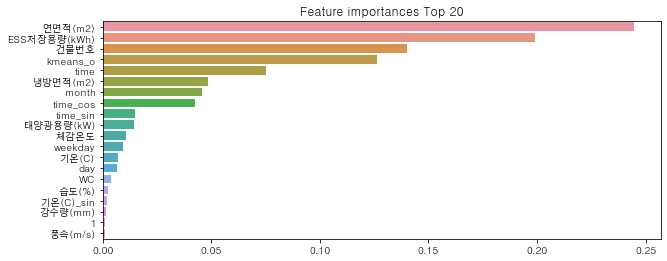

,건물유형,유형별_score
0,공공,7.739307


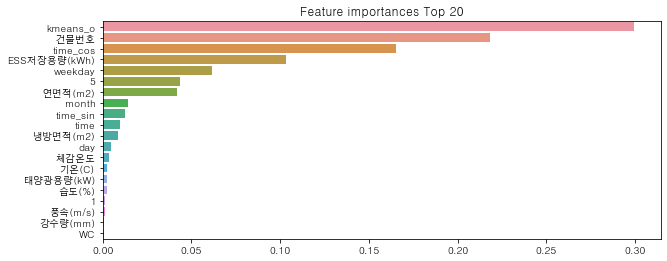

,건물유형,유형별_score
0,대학교,4.995519


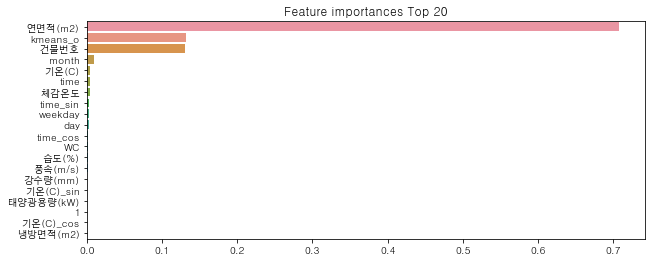

,건물유형,유형별_score
0,데이터센터,0.616094


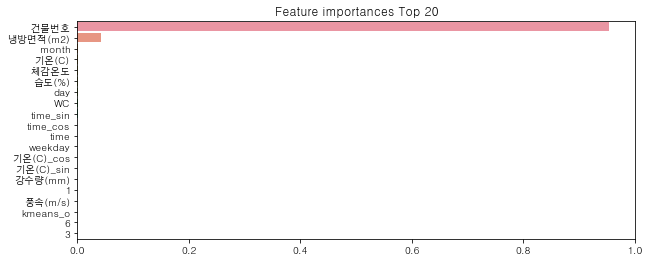

,건물유형,유형별_score
0,백화점및아울렛,6.01025


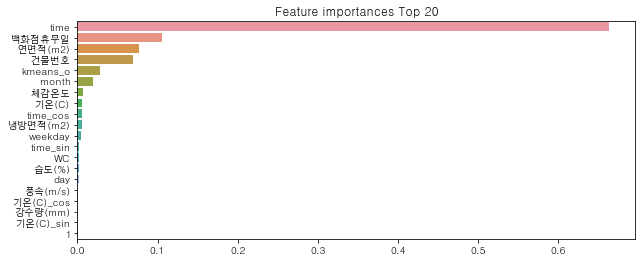

,건물유형,유형별_score
0,병원,4.057106


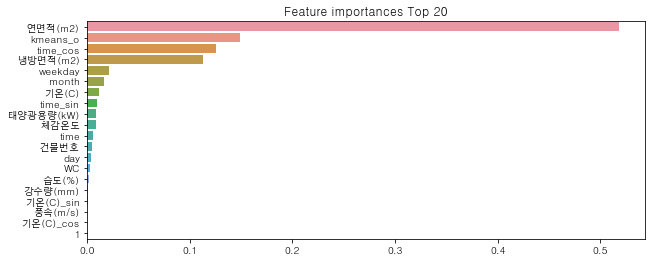

,건물유형,유형별_score
0,상용,8.466072


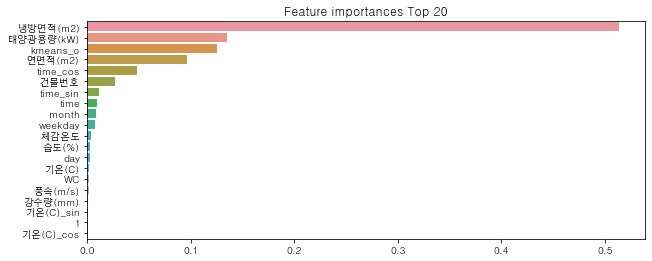

,건물유형,유형별_score
0,아파트,7.079334


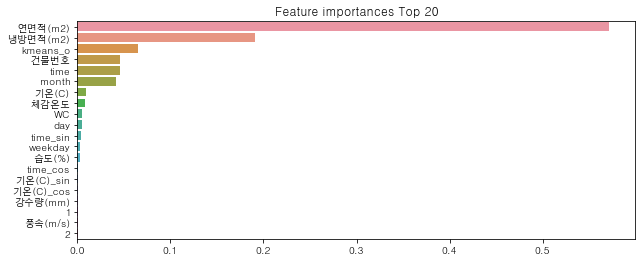

,건물유형,유형별_score
0,연구소,5.762439


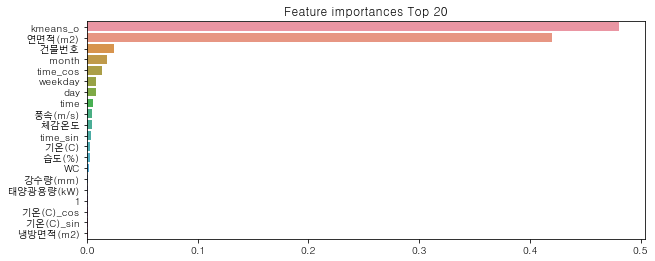

,건물유형,유형별_score
0,지식산업센터,4.589687


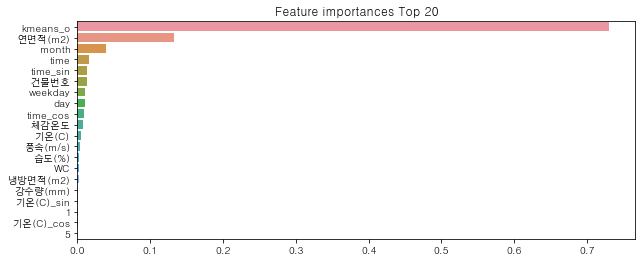

,건물유형,유형별_score
0,할인마트,6.496426


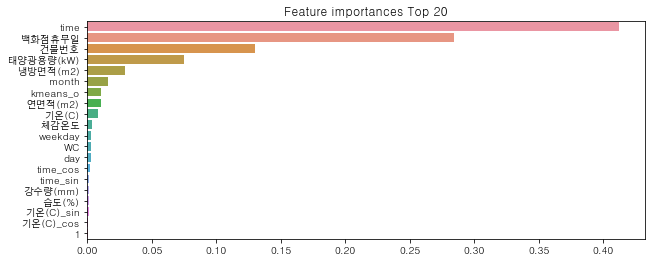

,건물유형,유형별_score
0,호텔및리조트,8.393033


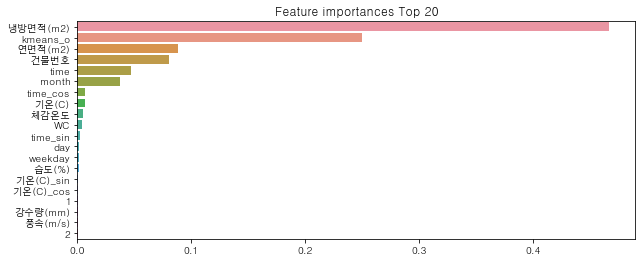

Wall time: 20.9 s


In [18]:
%%time 
metrics_type = pd.DataFrame()
for i in train['건물유형'].unique():
    temp_X_train = X_train[X_train['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
    
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':smape_model()})
    
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, smape(temp_y_test, y_preds)]).T
    temp.columns = ['건물유형', '유형별_score']
    metrics_type = metrics_type.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    

,건물번호,건물별_score
0,1.0,6.373978


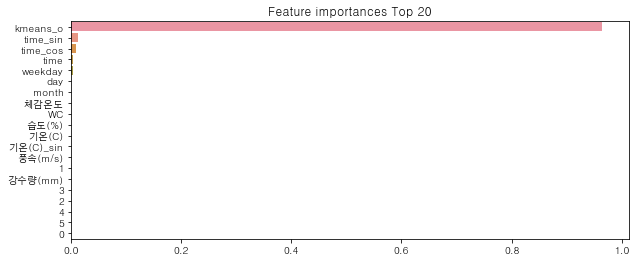

,건물번호,건물별_score
0,2.0,8.028722


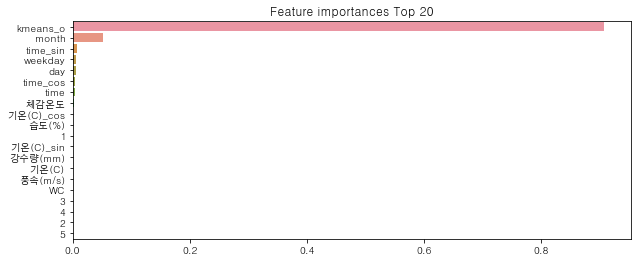

,건물번호,건물별_score
0,3.0,10.18257


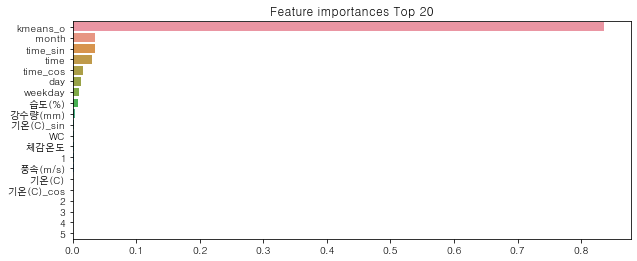

,건물번호,건물별_score
0,4.0,5.064576


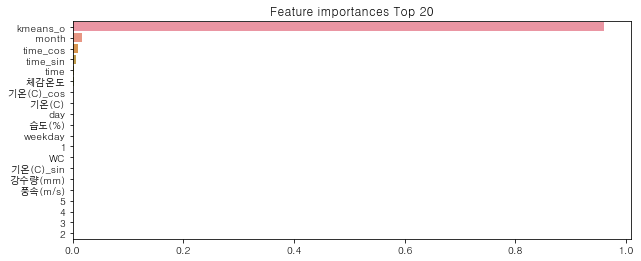

,건물번호,건물별_score
0,5.0,6.50661


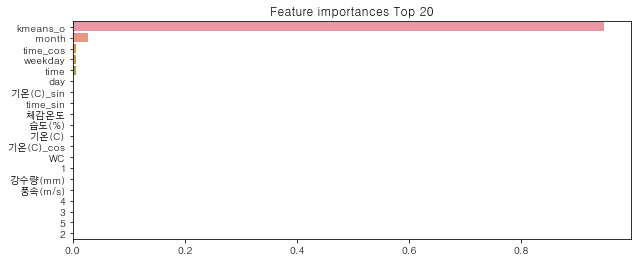

,건물번호,건물별_score
0,6.0,3.550561


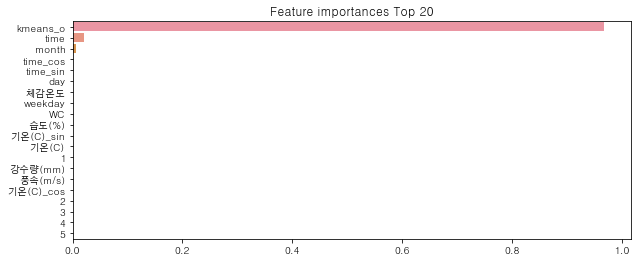

,건물번호,건물별_score
0,7.0,7.68503


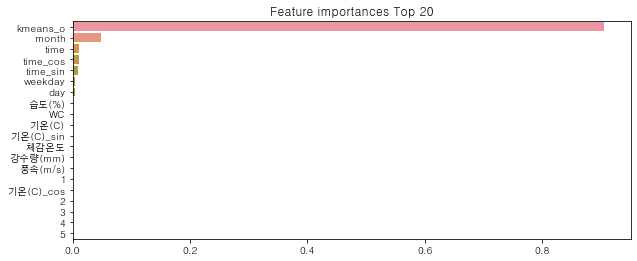

,건물번호,건물별_score
0,8.0,5.470767


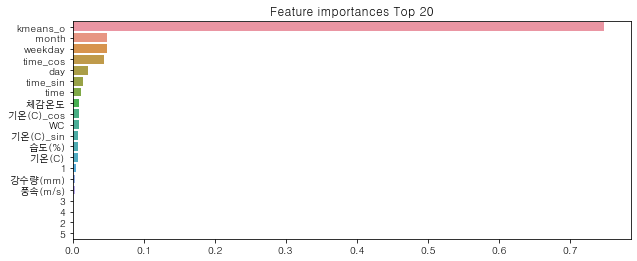

,건물번호,건물별_score
0,9.0,3.698289


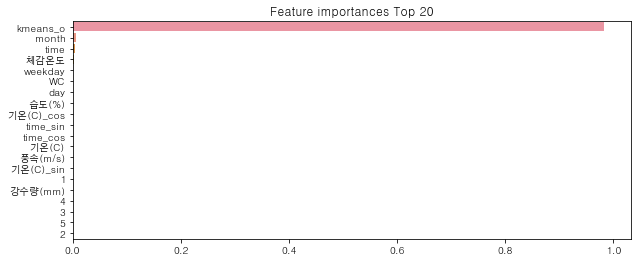

,건물번호,건물별_score
0,10.0,8.611425


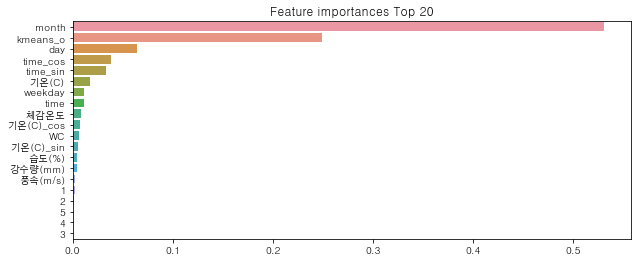

,건물번호,건물별_score
0,11.0,3.96939


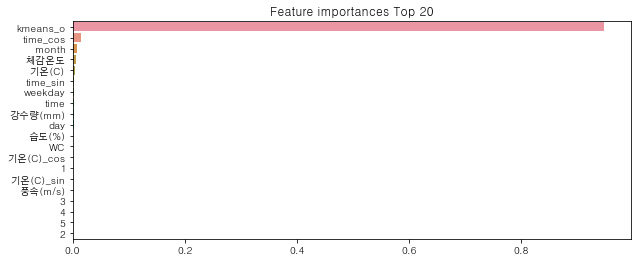

,건물번호,건물별_score
0,12.0,4.497015


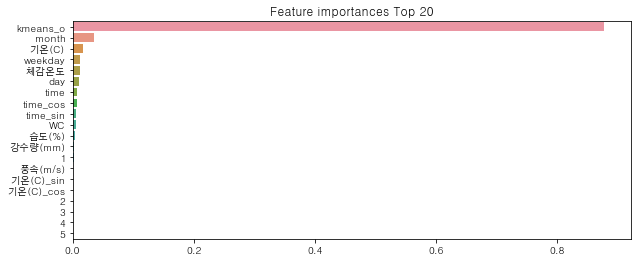

,건물번호,건물별_score
0,13.0,9.192819


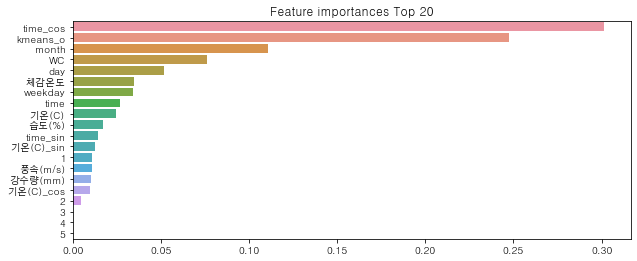

,건물번호,건물별_score
0,14.0,18.491705


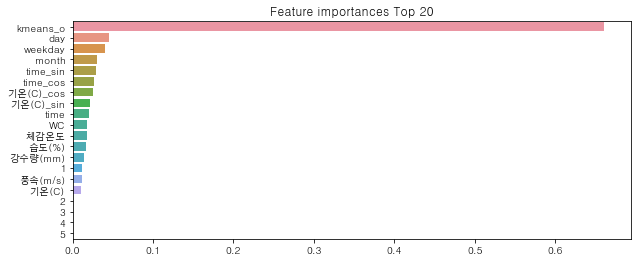

,건물번호,건물별_score
0,15.0,3.564769


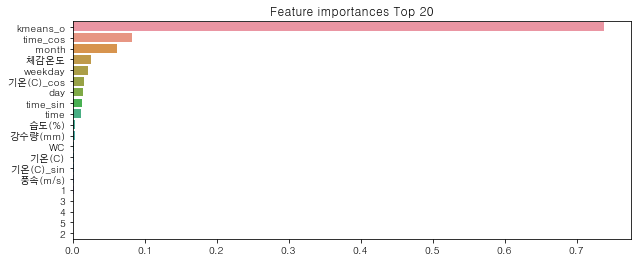

,건물번호,건물별_score
0,16.0,4.508051


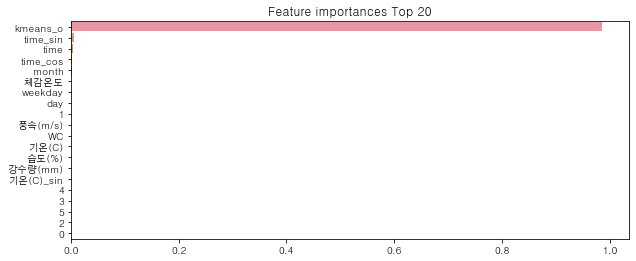

,건물번호,건물별_score
0,17.0,7.705028


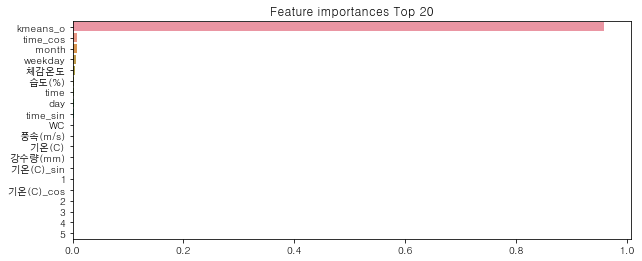

,건물번호,건물별_score
0,18.0,7.018523


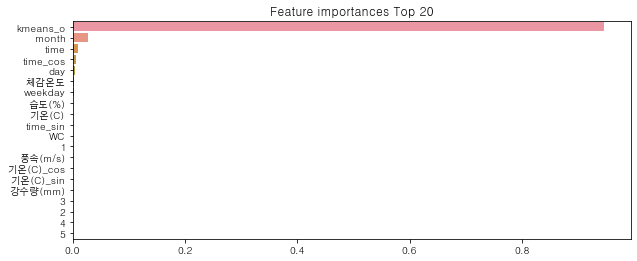

,건물번호,건물별_score
0,19.0,7.889964


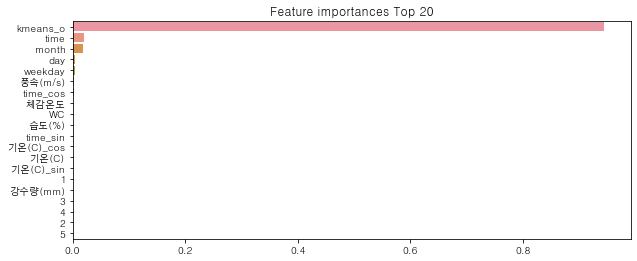

,건물번호,건물별_score
0,20.0,7.438497


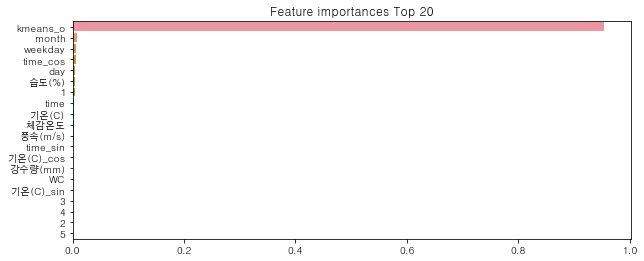

,건물번호,건물별_score
0,21.0,6.684196


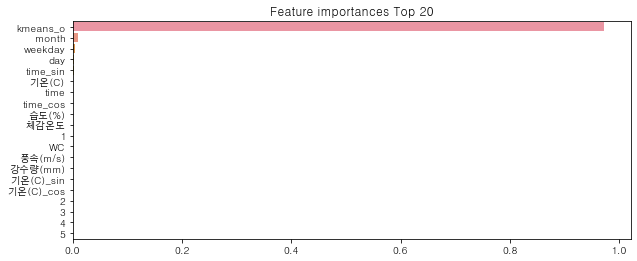

,건물번호,건물별_score
0,22.0,4.6578


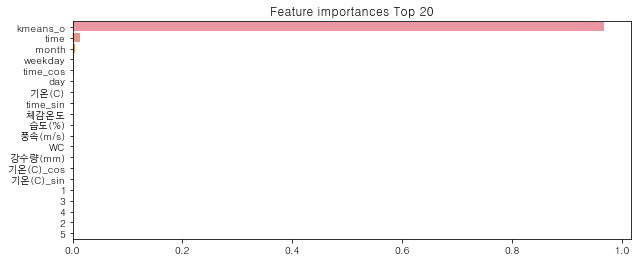

,건물번호,건물별_score
0,23.0,2.222702


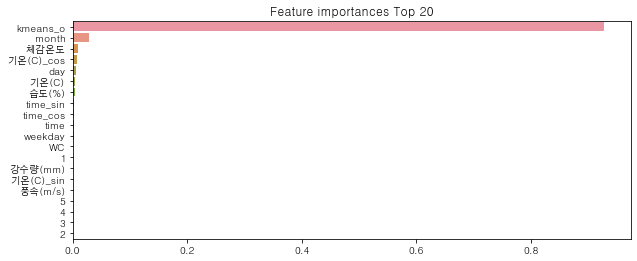

,건물번호,건물별_score
0,24.0,2.543827


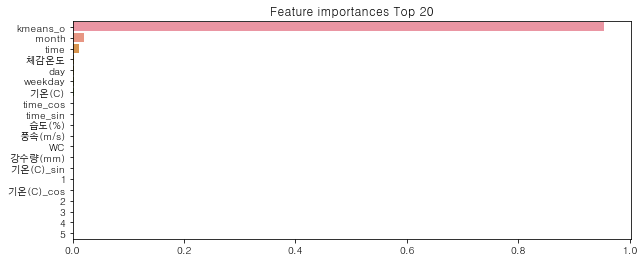

,건물번호,건물별_score
0,25.0,2.605392


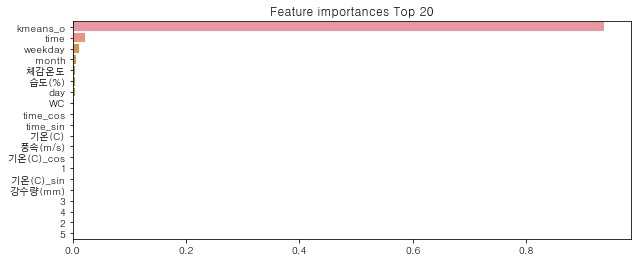

,건물번호,건물별_score
0,26.0,3.659355


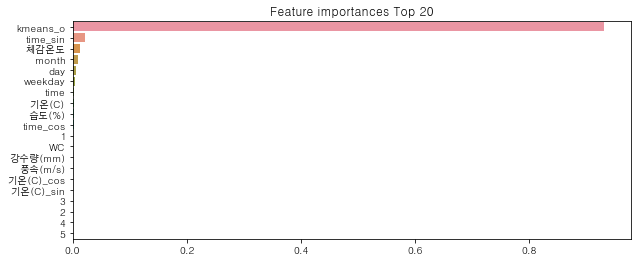

,건물번호,건물별_score
0,27.0,1.917552


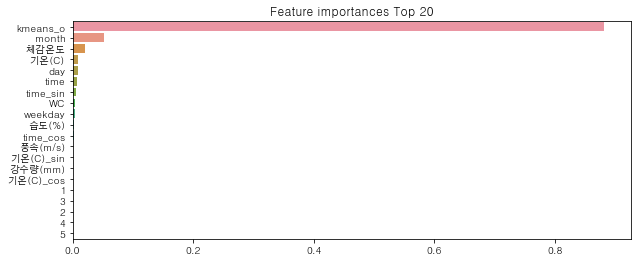

,건물번호,건물별_score
0,28.0,7.129381


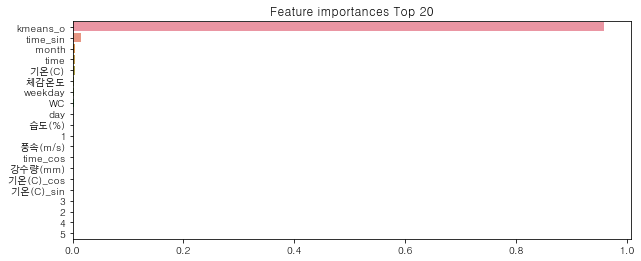

,건물번호,건물별_score
0,29.0,5.083428


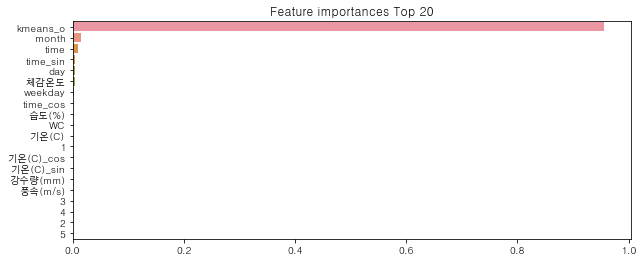

,건물번호,건물별_score
0,30.0,9.556842


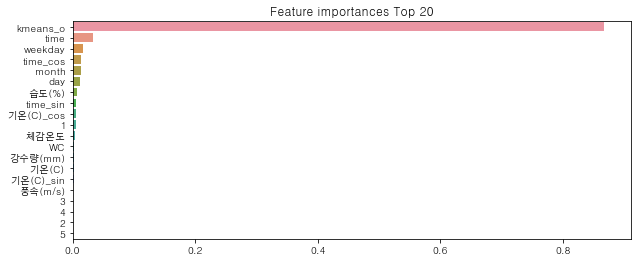

,건물번호,건물별_score
0,31.0,5.379104


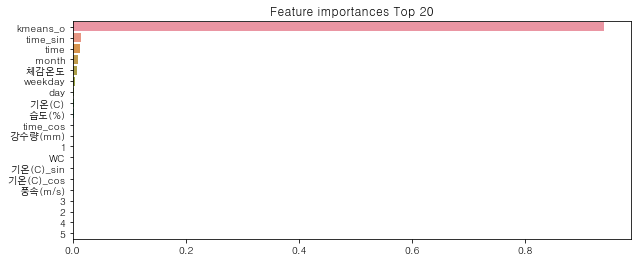

,건물번호,건물별_score
0,32.0,0.459643


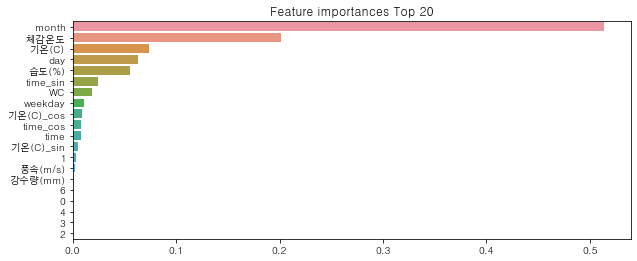

,건물번호,건물별_score
0,33.0,0.341308


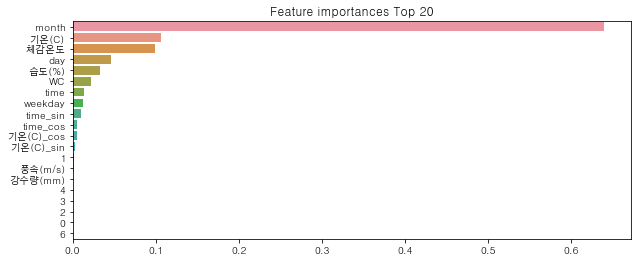

,건물번호,건물별_score
0,34.0,0.681746


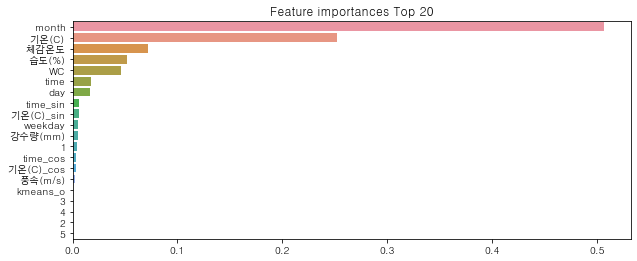

,건물번호,건물별_score
0,35.0,0.474441


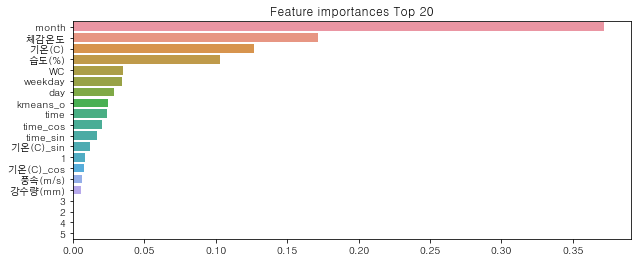

,건물번호,건물별_score
0,36.0,0.731983


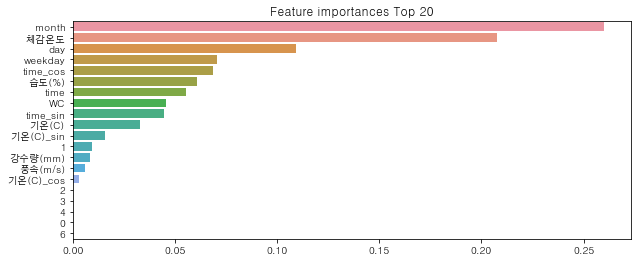

,건물번호,건물별_score
0,37.0,3.559451


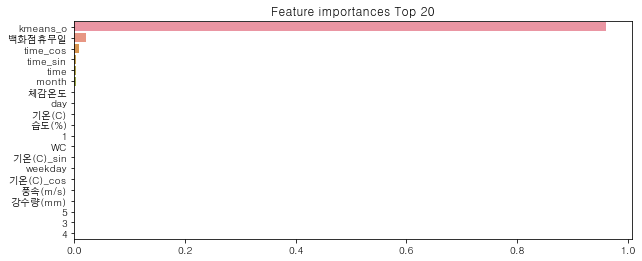

,건물번호,건물별_score
0,38.0,3.669285


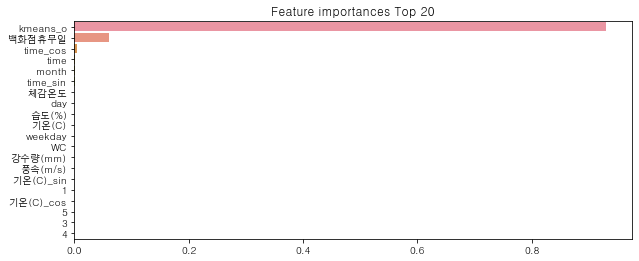

,건물번호,건물별_score
0,39.0,3.708494


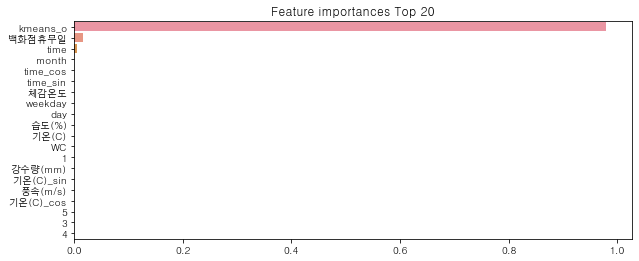

,건물번호,건물별_score
0,40.0,9.580099


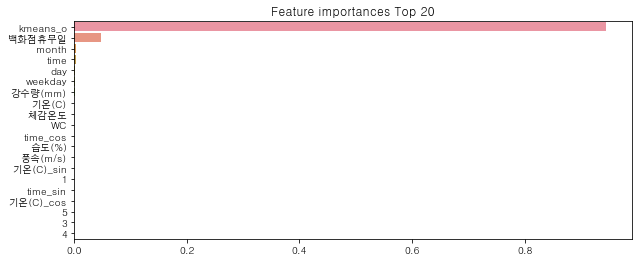

,건물번호,건물별_score
0,41.0,4.334479


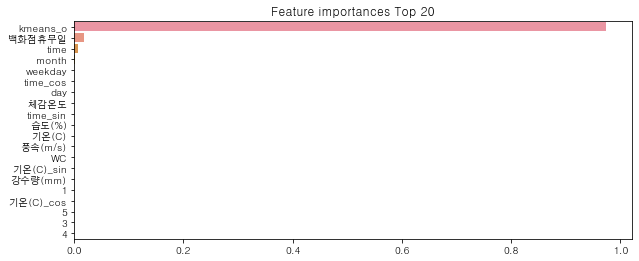

,건물번호,건물별_score
0,42.0,6.68787


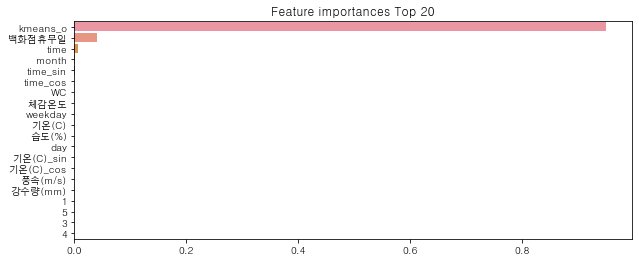

,건물번호,건물별_score
0,43.0,6.459878


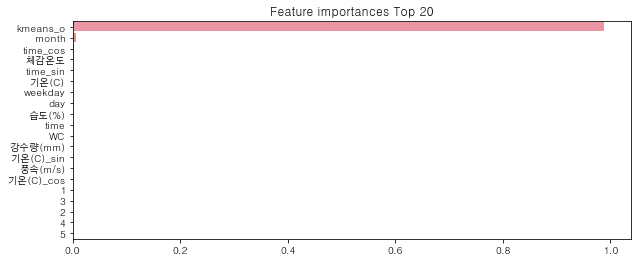

,건물번호,건물별_score
0,44.0,4.093721


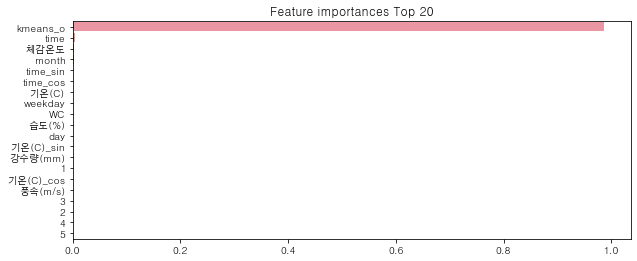

,건물번호,건물별_score
0,45.0,2.282886


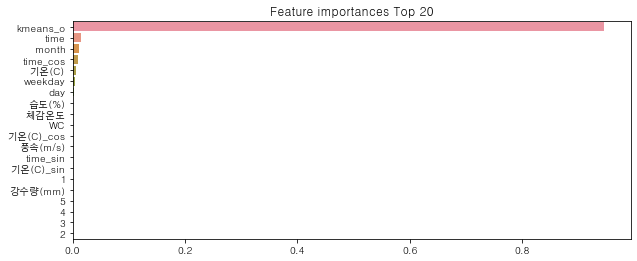

,건물번호,건물별_score
0,46.0,7.481242


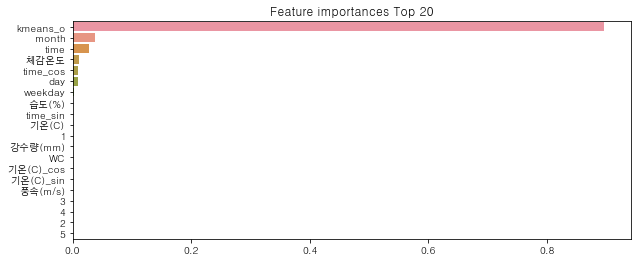

,건물번호,건물별_score
0,47.0,4.50302


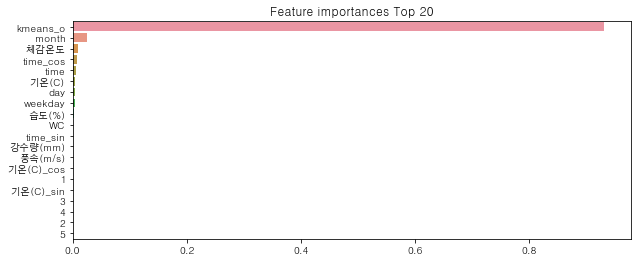

,건물번호,건물별_score
0,48.0,2.469406


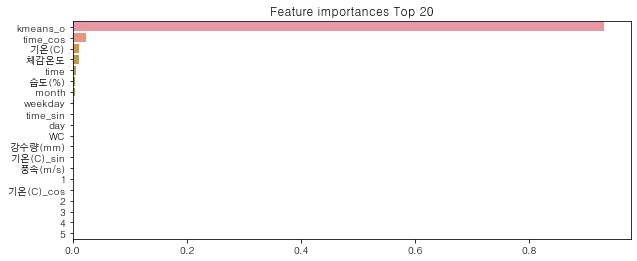

,건물번호,건물별_score
0,49.0,3.750754


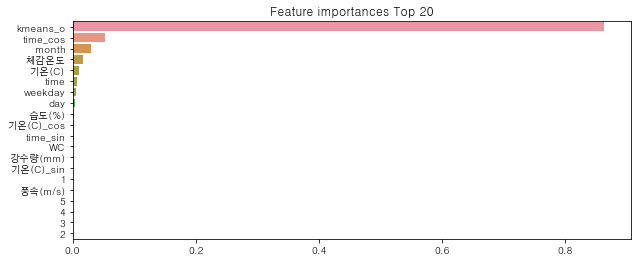

,건물번호,건물별_score
0,50.0,3.188376


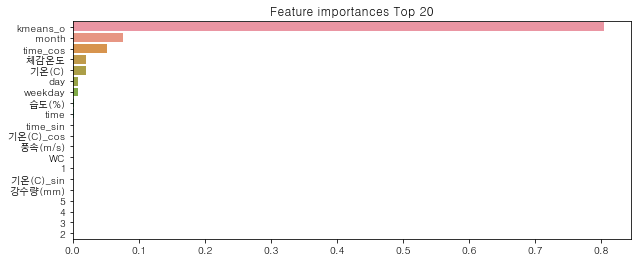

,건물번호,건물별_score
0,51.0,5.552098


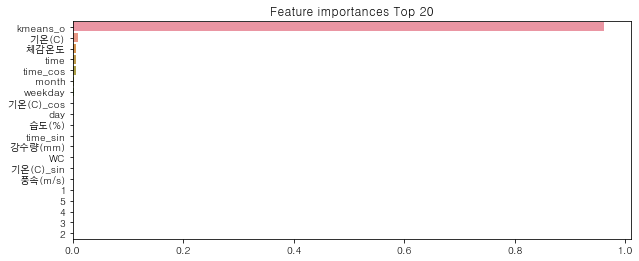

,건물번호,건물별_score
0,52.0,3.850753


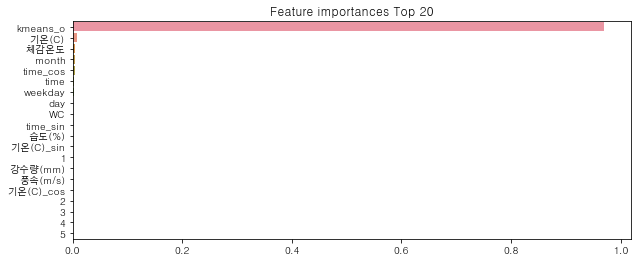

,건물번호,건물별_score
0,53.0,12.841467


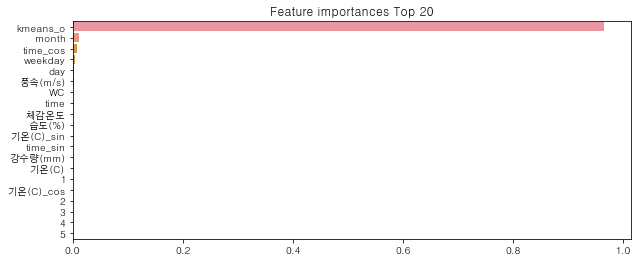

,건물번호,건물별_score
0,54.0,20.469391


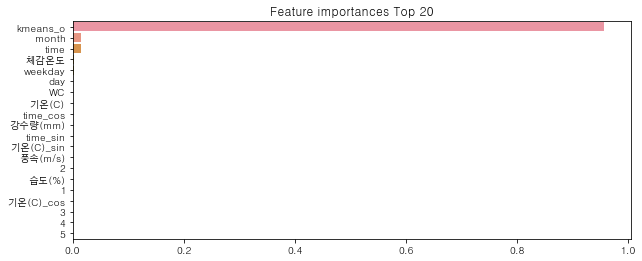

,건물번호,건물별_score
0,55.0,1.650962


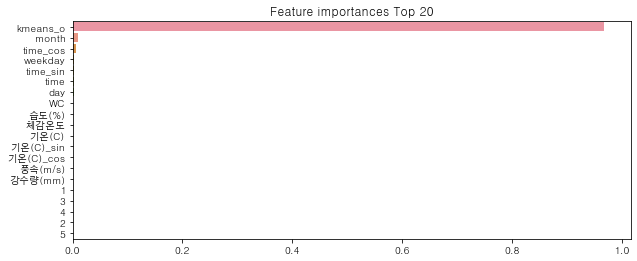

,건물번호,건물별_score
0,56.0,0.902109


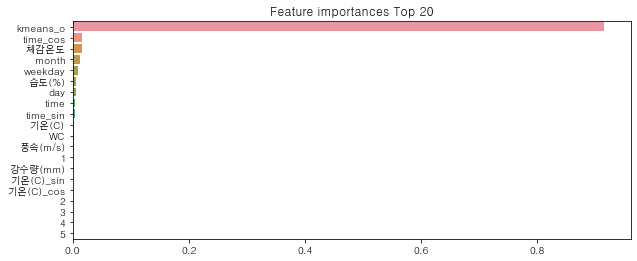

,건물번호,건물별_score
0,57.0,5.865801


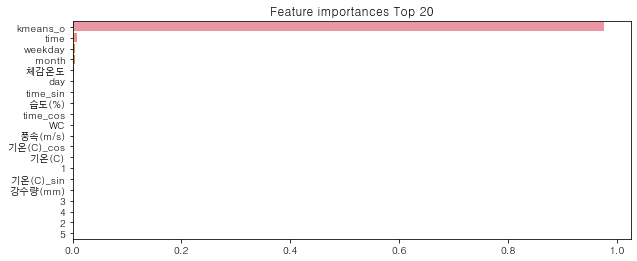

,건물번호,건물별_score
0,58.0,0.534321


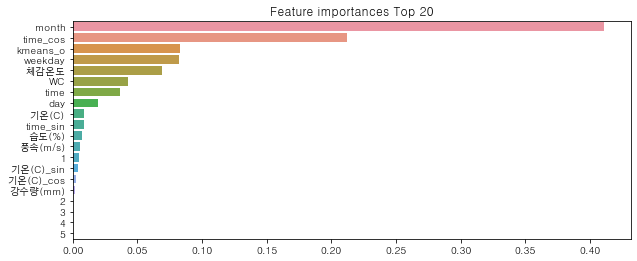

,건물번호,건물별_score
0,59.0,5.675966


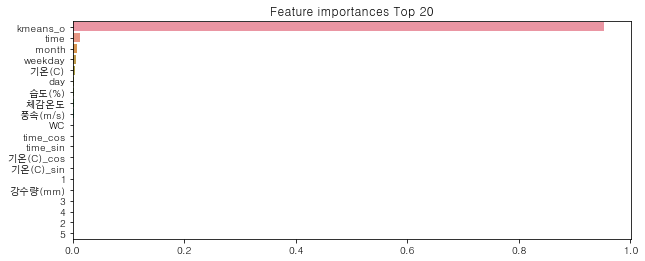

,건물번호,건물별_score
0,60.0,5.459976


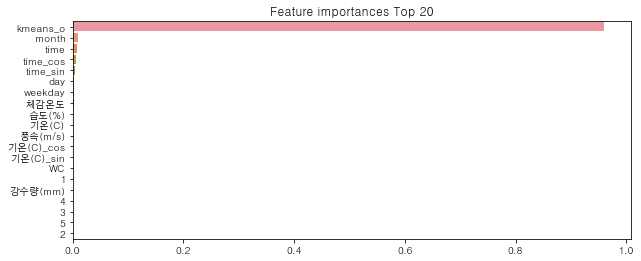

,건물번호,건물별_score
0,61.0,5.082927


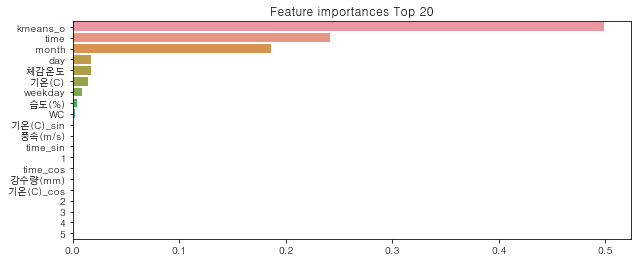

,건물번호,건물별_score
0,62.0,5.205664


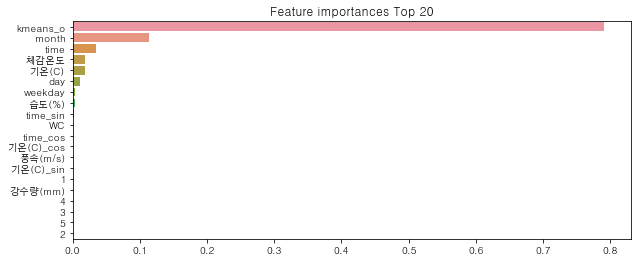

,건물번호,건물별_score
0,63.0,6.718839


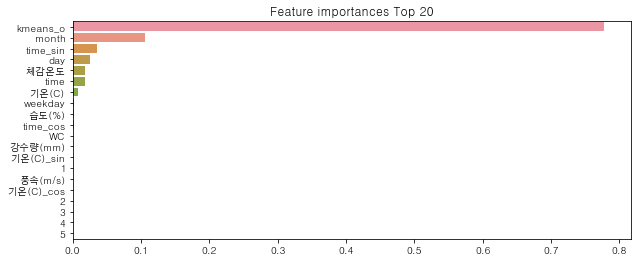

,건물번호,건물별_score
0,64.0,4.822739


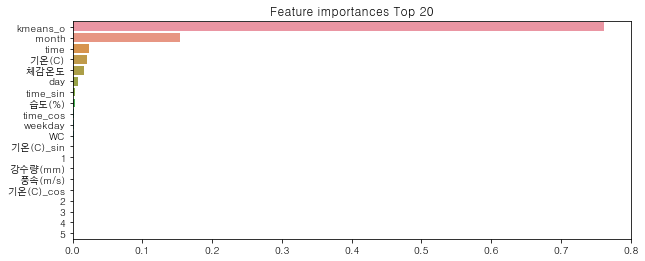

,건물번호,건물별_score
0,65.0,9.606494


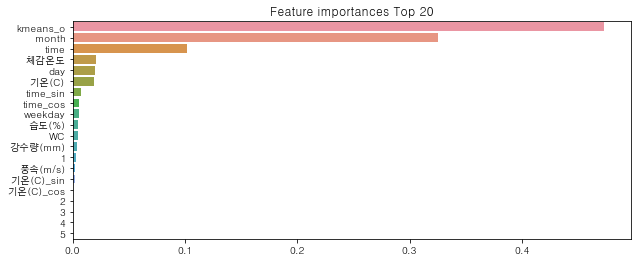

,건물번호,건물별_score
0,66.0,6.385036


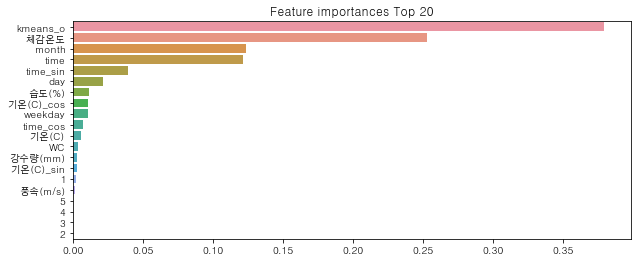

,건물번호,건물별_score
0,67.0,9.491436


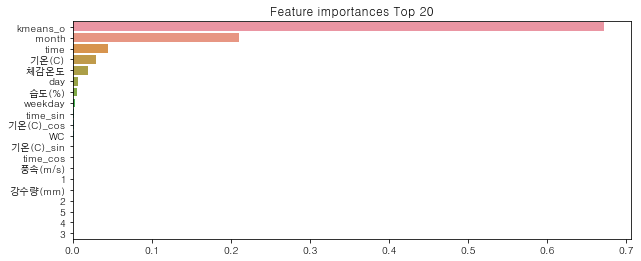

,건물번호,건물별_score
0,68.0,4.084284


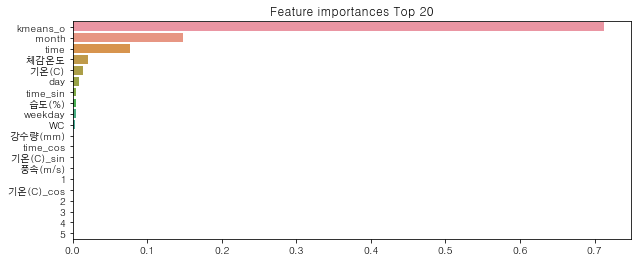

,건물번호,건물별_score
0,69.0,3.136063


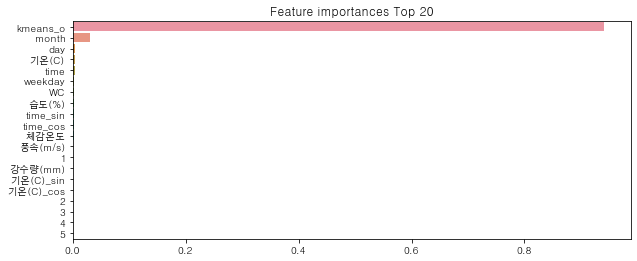

,건물번호,건물별_score
0,70.0,4.564239


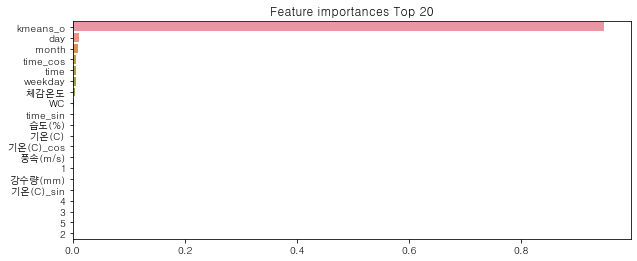

,건물번호,건물별_score
0,71.0,4.954407


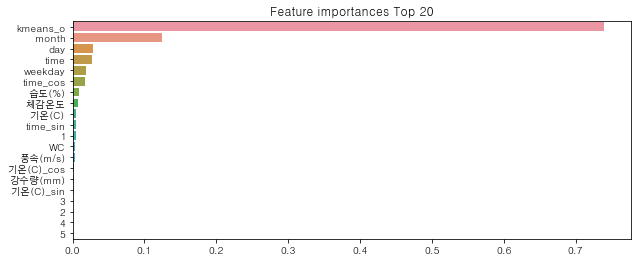

,건물번호,건물별_score
0,72.0,6.548009


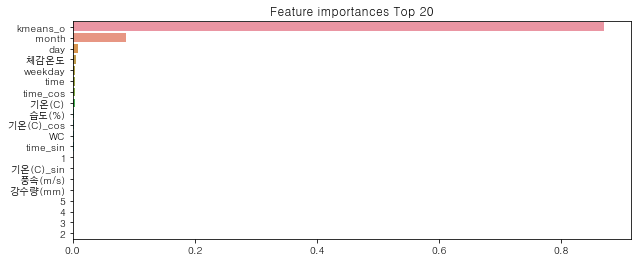

,건물번호,건물별_score
0,73.0,4.646145


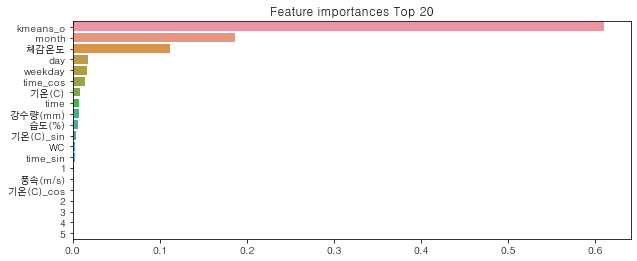

,건물번호,건물별_score
0,74.0,6.045186


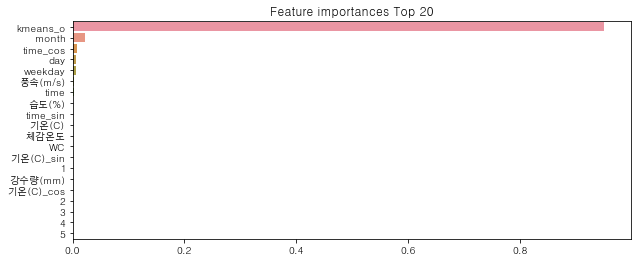

,건물번호,건물별_score
0,75.0,6.555063


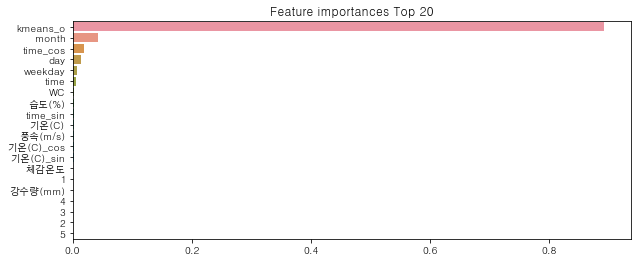

,건물번호,건물별_score
0,76.0,4.497482


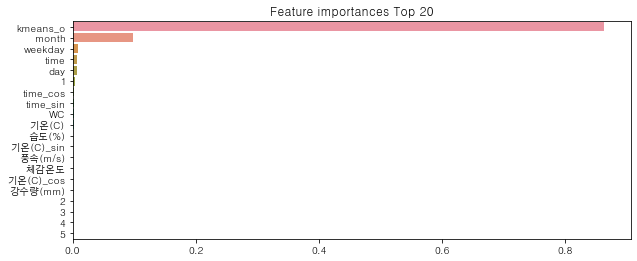

,건물번호,건물별_score
0,77.0,2.83241


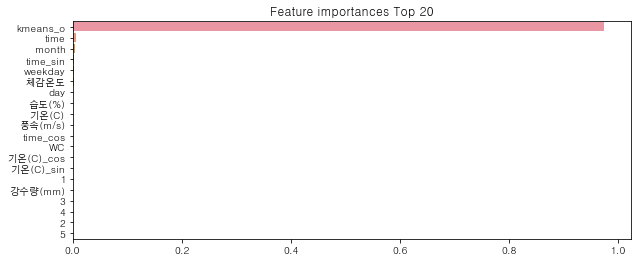

,건물번호,건물별_score
0,78.0,4.408034


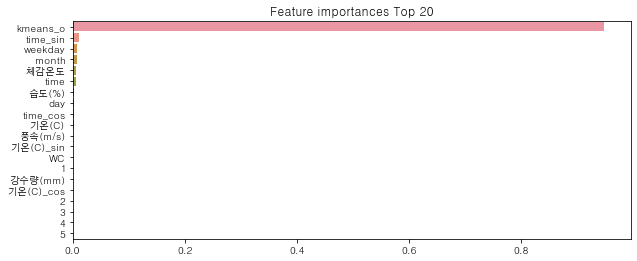

,건물번호,건물별_score
0,79.0,3.880936


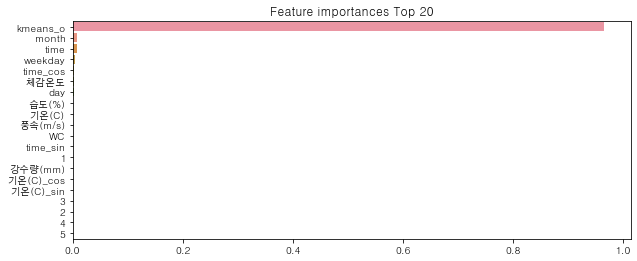

,건물번호,건물별_score
0,80.0,4.181214


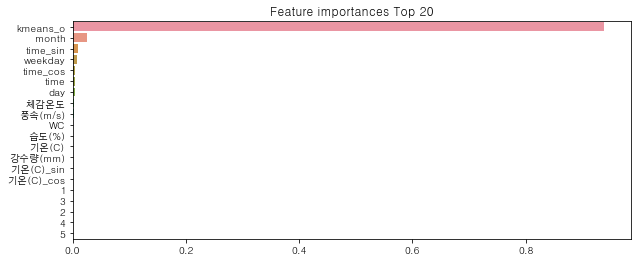

,건물번호,건물별_score
0,81.0,4.36274


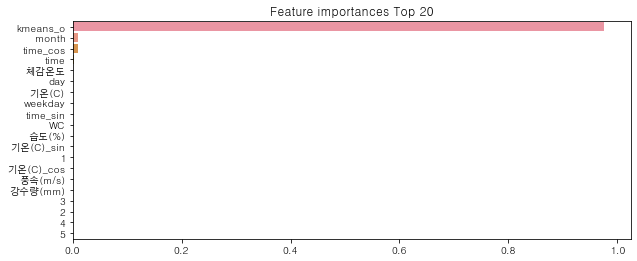

,건물번호,건물별_score
0,82.0,4.945654


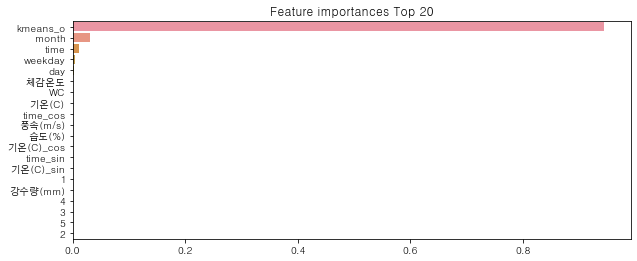

,건물번호,건물별_score
0,83.0,3.681584


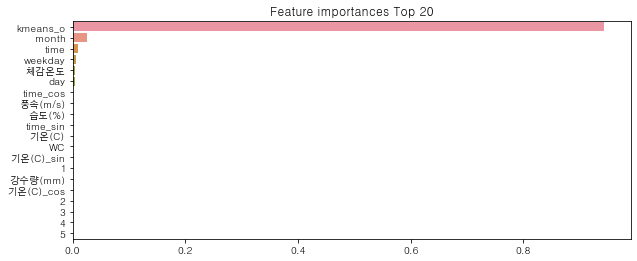

,건물번호,건물별_score
0,84.0,3.299127


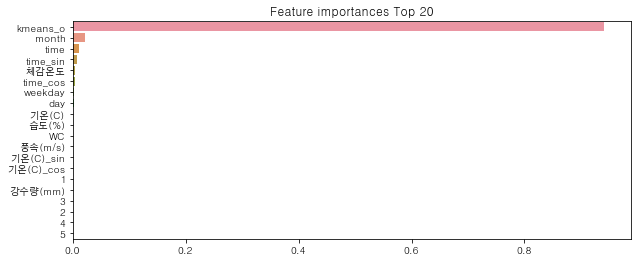

,건물번호,건물별_score
0,85.0,3.514651


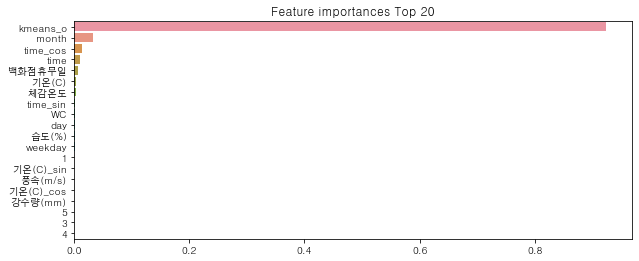

,건물번호,건물별_score
0,86.0,4.501015


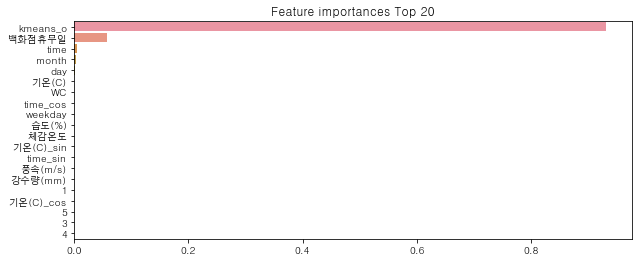

,건물번호,건물별_score
0,87.0,9.441785


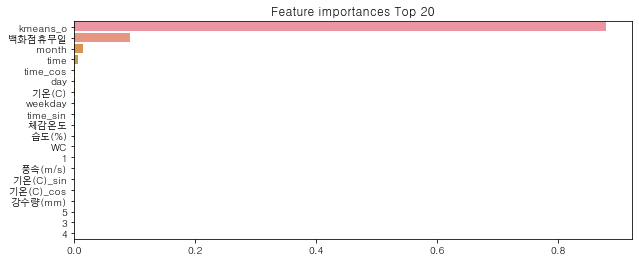

,건물번호,건물별_score
0,88.0,3.848864


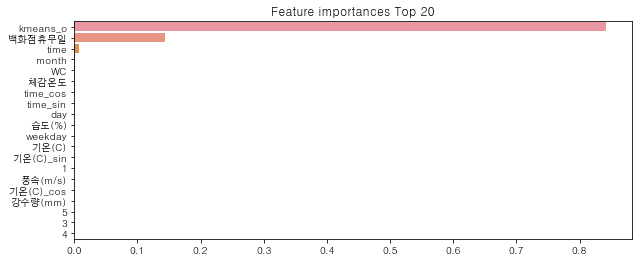

,건물번호,건물별_score
0,89.0,4.327391


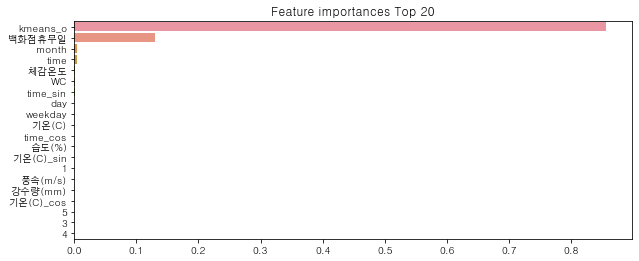

,건물번호,건물별_score
0,90.0,4.801538


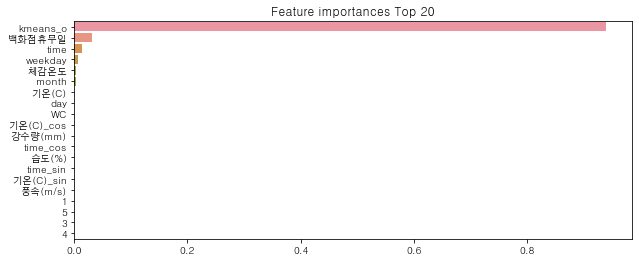

,건물번호,건물별_score
0,91.0,13.593326


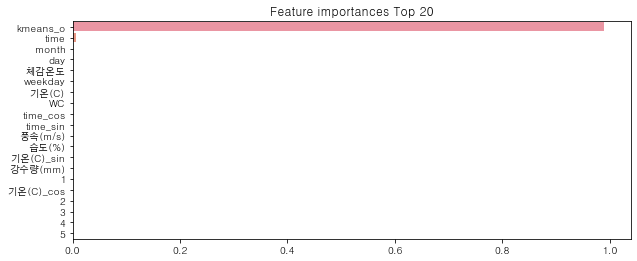

,건물번호,건물별_score
0,92.0,4.816921


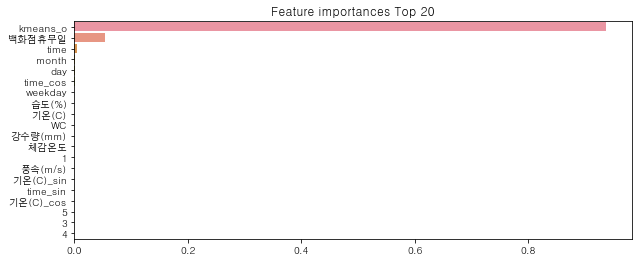

,건물번호,건물별_score
0,93.0,6.076588


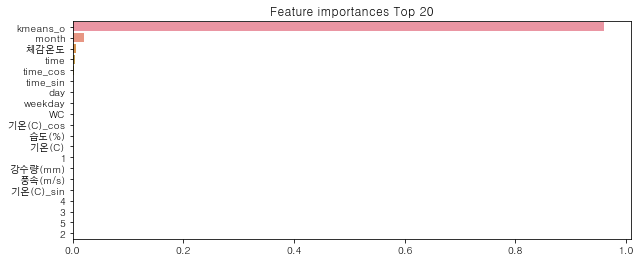

,건물번호,건물별_score
0,94.0,7.928609


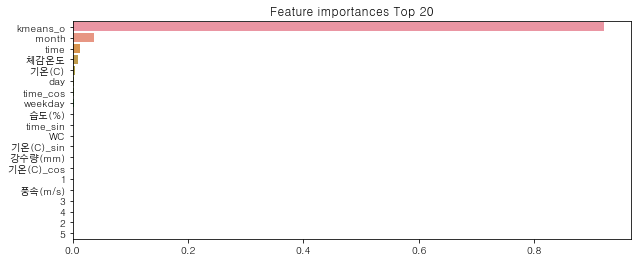

,건물번호,건물별_score
0,95.0,16.786173


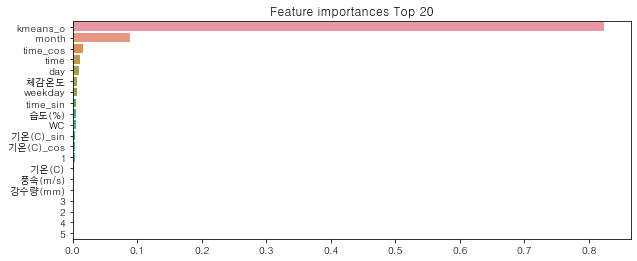

,건물번호,건물별_score
0,96.0,3.209593


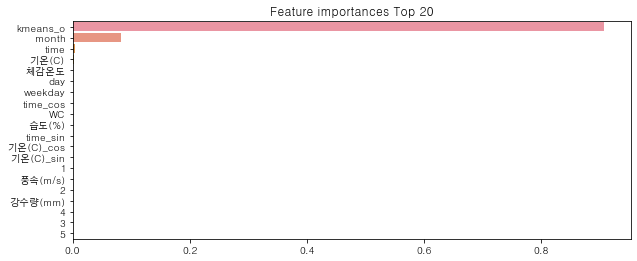

,건물번호,건물별_score
0,97.0,4.85858


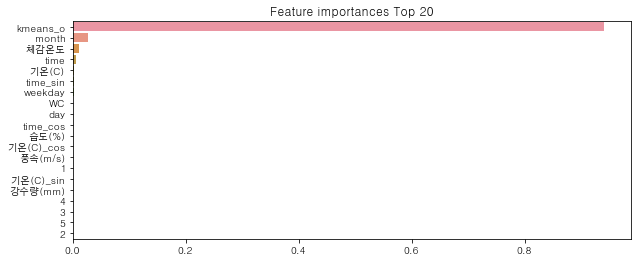

,건물번호,건물별_score
0,98.0,14.235468


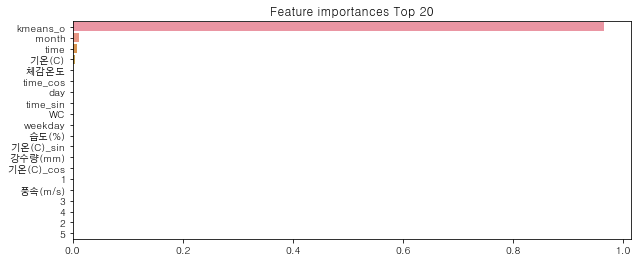

,건물번호,건물별_score
0,99.0,3.99019


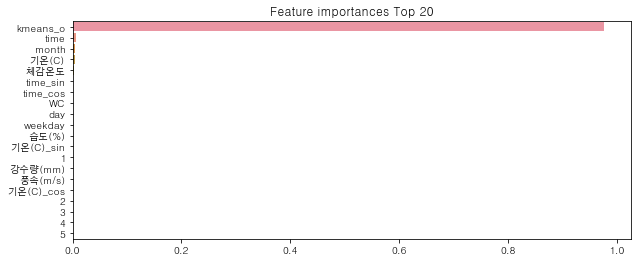

,건물번호,건물별_score
0,100.0,6.1266


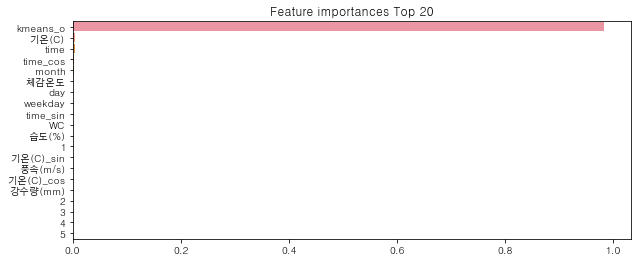


Wall time: 59.2 s


In [19]:
%%time 
metrics_bno = pd.DataFrame()
for i in train['건물번호'].unique():

    temp_X_train = X_train[X_train['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
        
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':smape_model()})
    
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, smape(temp_y_test, y_preds)]).T
    temp.columns = ['건물번호', '건물별_score']
    metrics_bno = metrics_bno.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    print()

In [20]:
metrics_bno['건물번호'] = metrics_bno['건물번호'].astype(int)

In [21]:
metrics_bno = metrics_bno.merge(building_info[['건물유형','건물번호']], on=['건물번호'])

In [22]:
metrics = metrics_bno.merge(metrics_type, on=['건물유형'])
metrics[:2]

,건물번호,건물별_score,건물유형,유형별_score
0,1,6.373978,건물기타,8.273131
1,2,8.028722,건물기타,8.273131


In [23]:
# 유형보다 건물이 더 좋은 스코어를 가지는 건물번호 list
bno = metrics[metrics['건물별_score'] < metrics['유형별_score']]['건물번호'].values
len(bno), bno

(71,
 array([  1,   2,   4,   5,   6,   7,   8,   9,  11,  12,  15,  16,  17,
         18,  20,  21,  22,  23,  24,  25,  26,  27,  32,  33,  35,  37,
         38,  39,  41,  44,  45,  48,  49,  50,  52,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  66,  68,  69,  70,  71,  73,  76,
         77,  78,  79,  80,  81,  83,  84,  85,  86,  88,  89,  90,  92,
         93,  94,  96,  97,  99, 100]))

In [24]:
metrics_type['유형별_score'].mean(), metrics_bno['건물별_score'].mean()
# (7.026821963284757, 6.107093822048833)

(6.039866482523458, 5.581417976273863)

In [25]:
# 가중 평균 
metrics_type['유형별_score'].mean() * ((100-len(bno))/100) + metrics_bno['건물별_score'].mean() * (len(bno)/100)

5.714368043086245

In [26]:
# 5.77847481671447 
# 5.5095065710217

In [27]:
metrics['score'] = metrics['유형별_score'] 
metrics.loc[metrics['건물번호'].isin(bno), 'score'] = metrics['건물별_score']

In [28]:
metrics['건물이낫다'] = metrics['건물별_score'] < metrics['유형별_score']

In [29]:
metrics.to_excel('오차큰것부터_20230821_2.xlsx')

## Inference & Submit

In [30]:
%%time
result_type = pd.DataFrame()
for i in train['건물유형'].unique():
    
    temp_X_train = train[train['건물유형'] == i].drop(['건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':smape_model()})
    
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물유형'] == i].drop(['건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_type = result_type.append( pd.concat([test[test['건물유형'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_유형별']).reset_index()], axis=1) )
    
result_type.shape    

Wall time: 22.2 s


(16800, 36)

In [31]:
%%time
result_bno = pd.DataFrame()
for i in train['건물번호'].unique():
    
    temp_X_train = train[train['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':smape_model()})
    
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_bno = result_bno.append( pd.concat([test[test['건물번호'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_건물별']).reset_index()], axis=1) )
    
result_bno.shape    

Wall time: 28 s


(16800, 36)

In [32]:
result = result_type[['num_date_time','건물번호','answer_유형별','weekday', 'time']].merge(result_bno[['num_date_time','건물번호','answer_건물별']], on=['num_date_time','건물번호'])
result['answer'] = result['answer_유형별'] 
result.loc[result['건물번호'].isin(bno), 'answer'] = result['answer_건물별']

# 후처리 
postprocessing = train.groupby(['건물번호', 'weekday','time'])['전력소비량(kWh)'].min().reset_index()
result = result.merge(postprocessing, on=['건물번호', 'weekday','time'])
result.loc[result['answer'] < result['전력소비량(kWh)'], 'answer'] = result['전력소비량(kWh)']

result[['num_date_time','answer']].to_csv('20230821_2.csv', index=False)